# 결정 트리
캔에 인쇄된 알코올 도수, 당도, pH 값으로 와인 종류 구별할 방법 찾기.  
로지스틱 회귀 모델을 적용해볼까?

## 로지스틱 회귀로 와인 분류하기
링크 연결해서 데이터셋 불러오기

In [2]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

와인 데이터셋을 판다스 데이터프레임으로 제대로 읽어 들였는지 head() 메서드로 처음 5개의 샘플 확인

In [3]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


판다스 데이터프레임의 유용한 메서드
- into() 메서드 : 데이터프레임의 각 열의 데이터 타입과 누락된 데이터가 있는지 확인.

In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


누락된 값이 있다면?  
그 데이터를 버리거나 평균값으로 채운 후 사용. 어떤 방법이 최선인지는 미리 알기 어려우므로 모두 시도해보기.  
여기서도 항상 훈련 세트의 통계 값으로 테스트 세트를 반환한다.

판다스 데이터프레임의 유용한 메서드
- describe() : 열에 대한 간략한 통계를 출력  
평균, 표준편차, 최소, 1사분위 수, 중간값(2사분위 수), 3사분위수, 최대

In [4]:
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


여기서 알 수 있는 것은 알코올 도수와 당도, pH 값으 스케일이 다르다는 것. 전처리 필요.  
그전에 판다스 데이터프레임을 넘파이 배열로 바꾸고 훈련 세트와 테스트 세트로 나누기

In [5]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [6]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

train_test_split() 함수는 설정값을 지정하지 않으면 25%를 테스트 세트로 지정.  
샘플 개수가 충분하므로 20% 정도만 테스트 세트로 나눔. test_size=0.2가 바로 이런 의미.  
만들어진 훈련 세트와 테스트 세트의 크기 확인.

In [7]:
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


전처리

In [9]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

이제 로지스틱 회귀 모델 훈련

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_scaled, train_target)

print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


점수가 높지 않다. 훈련 세트와 테스트 세트 점수가 모두 낮으니 다소 과소 적합된 것 같음.  
규제 매개변수 C의 갑을 바꿔보거나, solver 매개변수에서 다른 알고리즘을 선택할 수도 있음.  
또는 다항 특성을 만들어 추가하는 것도 방법.

### 설명하기 쉬운 모델과 어려운 모델
모델을 설명하기 위해 로지스틱 회귀가 학습한 계수와 절편을 출력.

In [11]:
print(lr.coef_, lr.intercept_)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


이 계수를 이용한 설명에 의하면 이 모델을 잘 이해할 수 없다. 이 숫자가 어떤 의미인지 설명하기도 어렵고, 더군다나 다항 특성을 추가한다면 설명하기가 더 어려울 것임.

순서도처럼 쉬운 방법으로 설명할 수 있는 모델을 만들어야 한다...!

## 결정 트리
데이터를 잘 나눌 수 있는 질문을 찾는다면 계속 질문을 추가해서 분류 정확도를 높일 수 있음.  
사이킷런의DecisionTreeClassifier 클래스를 사용해 결정 트리 모델을 훈련.

결정트리를 만들 때 왜 random_state를 지정하나요?  
노드에서 최적의 분할을 찾기 전에 특성의 순서를 적는다. 따라서 약간의 무작위성이 주입된다. 실행할 때마다 점수가 조금씩 달라질 수 있기 때문.  실전에서 필요하지 않음.

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.996921300750433
0.8592307692307692


훈련 세트에 대한 점수가 엄청 높은 데 반해 테스트 세트의 성능은 그에 비해 조금 낮으므로 과대 적합된 모델이다.  
이 모델을 그림으로 표현해보자.
- plot_tree() 함수 사용.

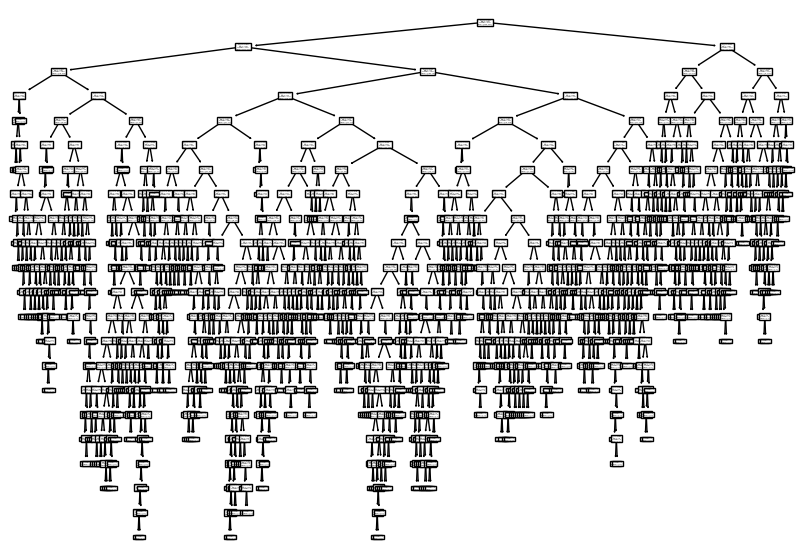

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

결정 트리는 위에서 아래로 거꾸로 자라남. 맨 위의 노드를 루트 노드, 맨 아래 끝에 달린 노드를 리프 노드라고 함.  
노드는 훈련 데이터의 특성에 대한 테스트를 표현. 가지는 테스트의 결과를 나타내면 일반적으로 하나의 노드는 2개의 가지를 가짐.

- max_depth 매개변수 : 트리의 깊이를 제한해서 출력.
- filled 매개변수 : 클래스에 맞게 노드에 색 칠하기.
- feature_names 매개변수 : 특성의 이름 전달하기

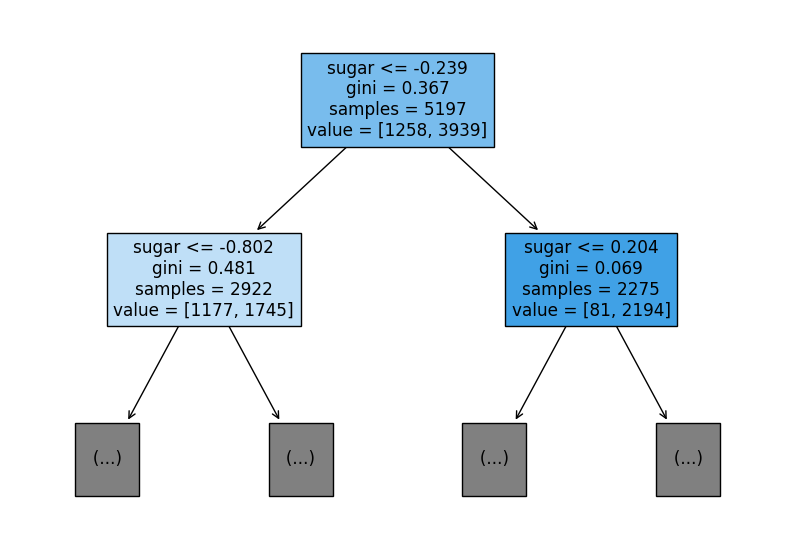

In [13]:
plt.figure(figsize=(10,7))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

테스트 조건, 불순도, 총 샘플 수, 클래스별 샘플 수의 정보가 나타남.

만약 결정 트리를 회귀 문제에 적용하면 리프 노드에 도달한 샘플의 타깃을 평균하여 예측값으로 사용.

#### 불순도
지니 불순도. DecisionTreeClassifier 클래스의 criterion 매개변수의 기본값이 'gini'.  
criterion 매개변수의 용도는 노드에서 데이터를 분할할 기준을 정하는 것.  
- 지니 불순도 = 1 -(음성클래스의 비율^2 + 양성 클래스 비율^2)

결정 트리 모델은 부모 노드와 자식 노드의 불순도 차이가 가능한 크도록 트리를 성장시킴.

부모 노드와 자식 노드의 불순도 차이를 계산하는 방법  
자식 노드의 불순도를 샘플 개수에 비례하여 모두 더하고, 부모 노드의 불순도에서 빼면 됨.  
- 부모의 불순도 - (왼쪽 노드 샘플 수 / 부모의 샘플 수) * 왼쪽 노드 불순도 - (오른쪽 노드 샘플 수 / 부모의 샘플 수) * 오른쪽 노드 불순도  
  
  
이러한 부모와 자식 노드 사이의 불순도 차이를 정보 이득이라고 함.

DecisionTreeClassifier 클래스에서 criterion='entropy'를 지정하여 엔트로피 불순도를 사용할 수 있음.  
엔트로피 불순도도 노드의 클래스 비율을 사용하지만 지니 불순도처럼 제곱이 아니라 밑이 2인 로그를 사용하여 곱함.  
- 음성클래스 비율 * log2(음성 클래스 비율) - 양성 클래스 비율 * log2(양성 클래스 비율)

지니 불순도와 엔트로피 불순도가 만든 결과의 차이는 크지 않아서 기본값이 지니 불순도를 주로 사용.

다만, 앞의 트리는 제한 없이 자라났기에 훈련 세트보다 테스트 세트에서 점수가 크게 낮았음.

### 가지치기
가지치기를 하지 않으면 훈련 세트에는 아주 잘 맞겠지만 테스트 세트에서 점수는 그에 못 미침.  
일반화가 잘 안 될 것 같다고 표현.

가지치기를 하는 가장 간단한 방법은 자라날 수 있는 트리의 최대 깊이를 지정하는 것.  
- max_depth 매개 변수 사용  
  
여기서는 3으로 지정

In [14]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


훈련 세트의 성능은 낮아졌지만 테스트 세트의 성능은 거의 그대로.

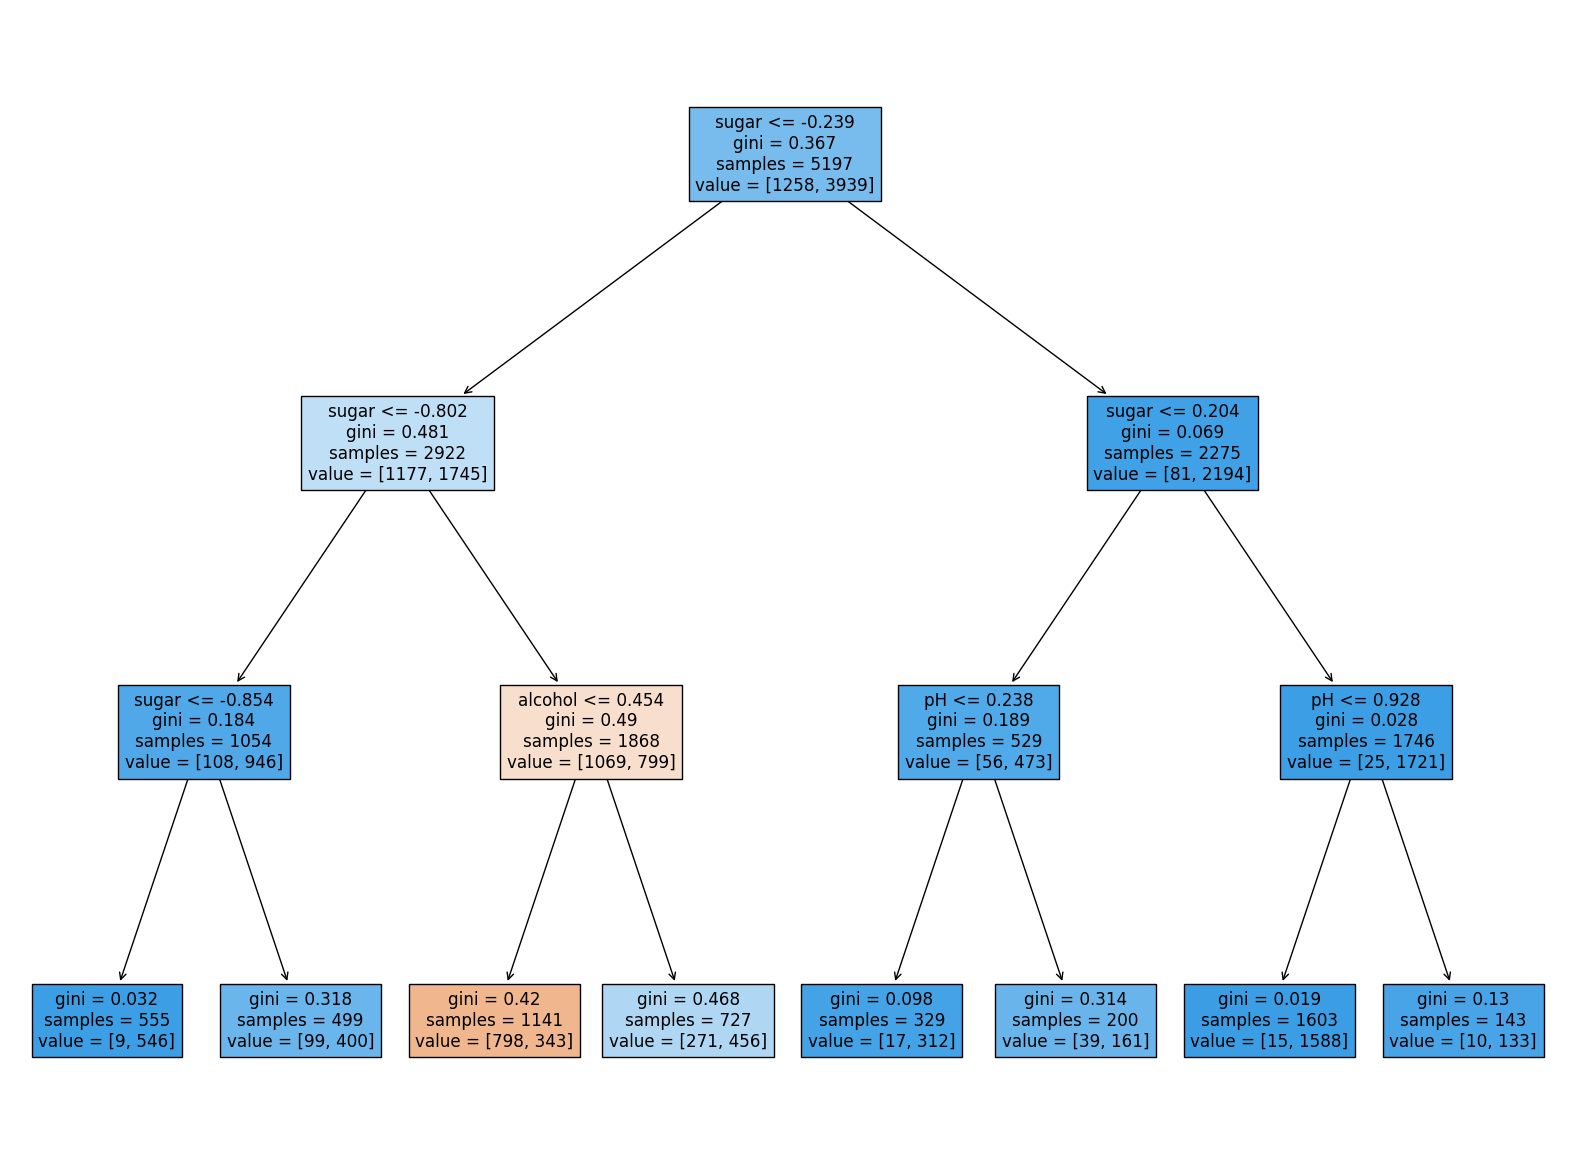

In [15]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

그런데 -0.802라는 당도를 어떻게 설명?  
불순도를 기준으로 샘플을 나누고 불순도는 클래스별 비율을 가지고 계산.  
샘플을 어떤 클래스 비율로 나누는지 계산할 때 특성값의 스케일은 계산에 영향을 미치지 않는다.  
표준화 전처리를 할 필요가 없다.  
  
그래서 앞서 전처리하기 전의 훈련 세트와 테스트 세트로 결정 트리 모델을 다시 훈련.

In [16]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


점수가 같다!!

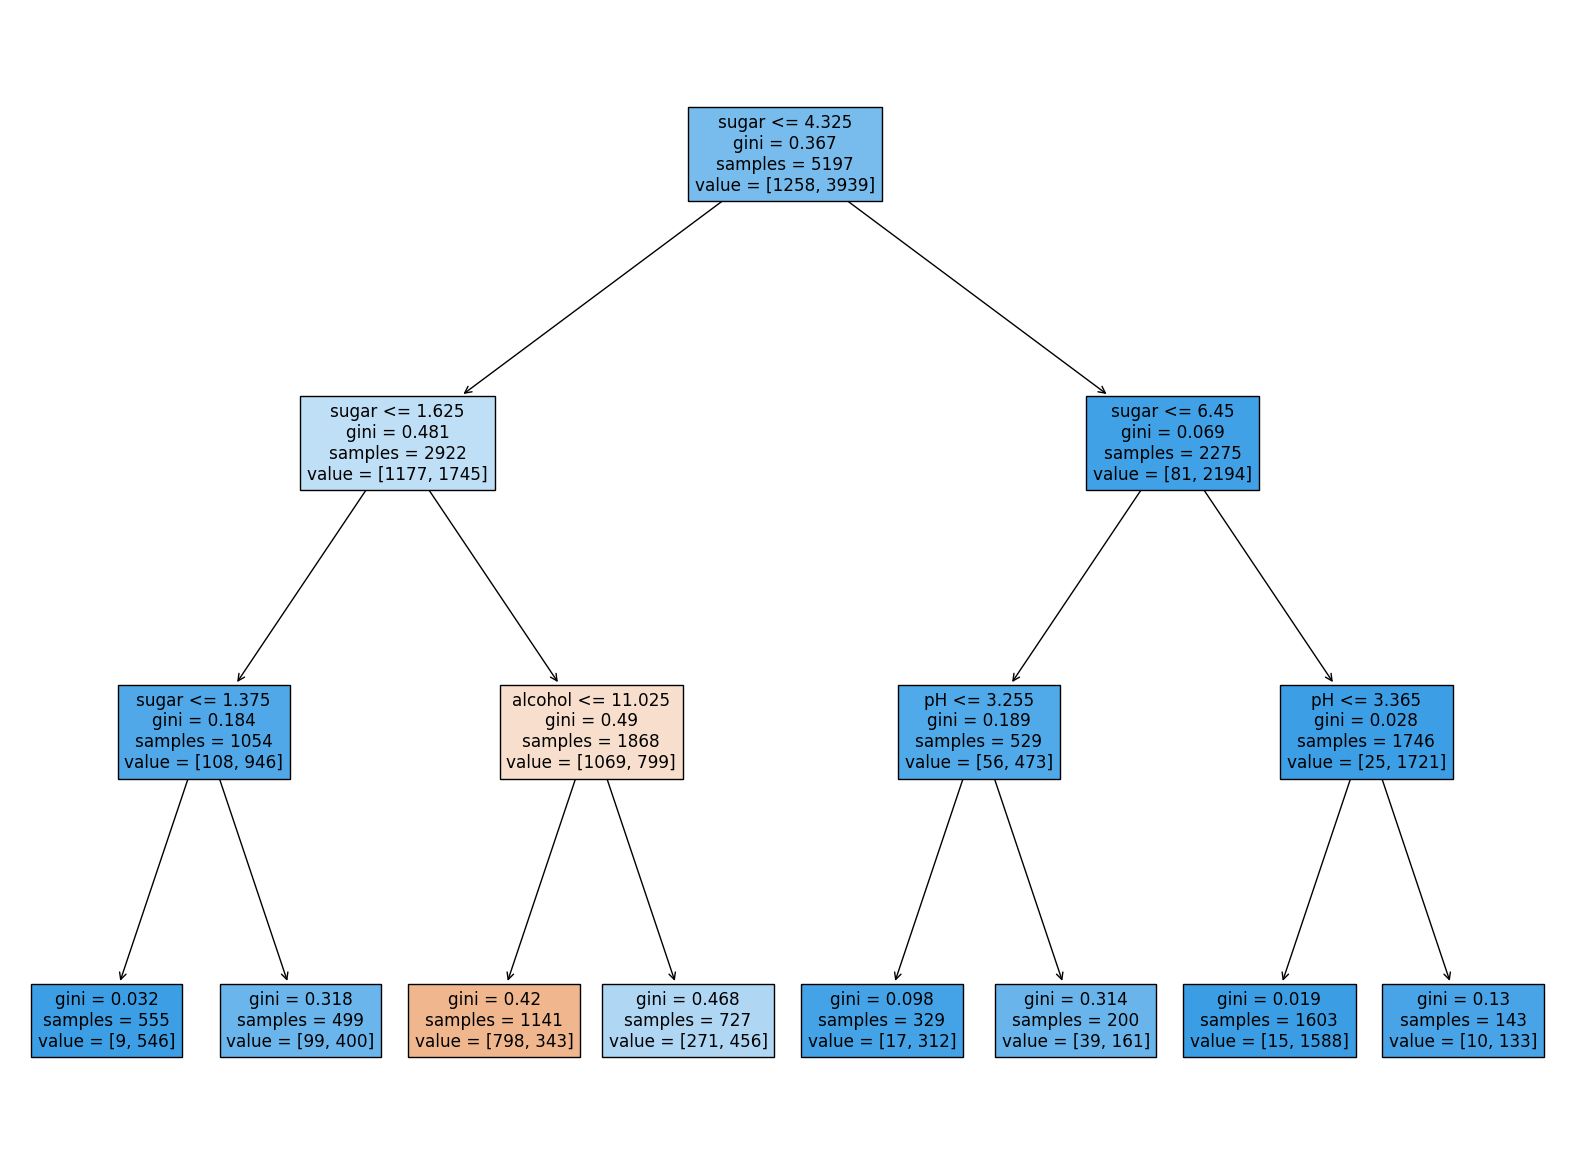

In [17]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

트리를 그려보았을 때 특성값을 표준점수로 바꾸지 않은 터라 이해하기가 훨씬 쉽다.  

결정 트리는 어떤 특성이 가장 유용한지 나타내는 특성 중요도를 계산해 줌.  
- feature_importances_ 속성에 저장.

In [18]:
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]


모두 더하면 1이 됨. 특성 중요도는 각 노드의 정보 이득과 전체 샘플에 대한 비율을 곱한 후 특성별로 더하여 계산.  
특성 중요도를 특성 선택에 활용할 수 있음.

# 정리
와인을 분류하는 이진 분류 로지스틱 회귀 모델을 훈련했으나 설명이 어려움.  
설명에 용이한 결정 트리를 사용.  
특성을 더 추가하지 않았음에도 성능이 더 좋았고, 깊이가 너무 깊지 않다면 비교적 설명하기 쉬움.  
또, 결정 트리는 많은 앙상블 학습 알고리즘의 기반이 되고, 앙상블 학습은 신경망과 함께 가장 높은 성능을 낸다.

## 확인문제

In [19]:
dt = DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8874350586877044
0.8615384615384616


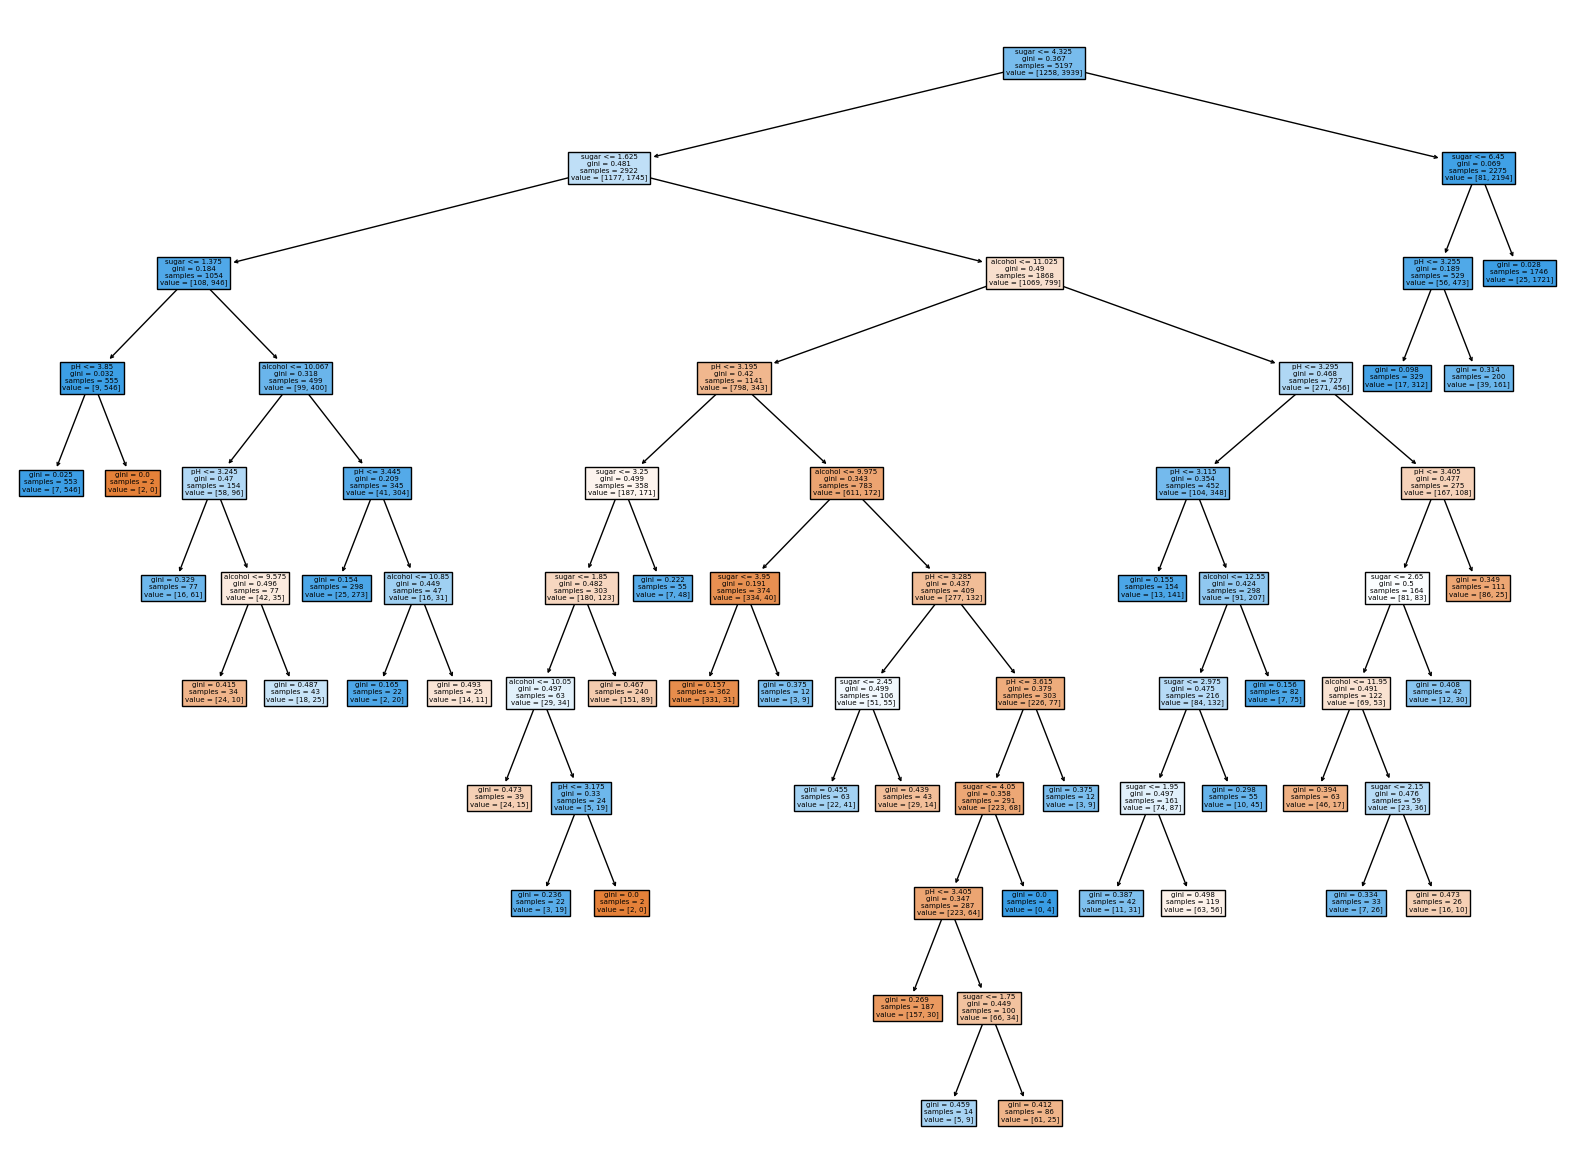

In [20]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()